# DSCI 552 Machine Learning for Data Science

# Final Project: Image CNN Classification

# Group1: Rui Xue, Zijun Tan, Siqi Qiao, Siyi Chen

In [ ]:
import keras
print(keras.__version__)

2.12.0


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
import random
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import EfficientNetB0, VGG16, ResNet50, InceptionV3
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

## Image Load and Label Extraction

---



In [ ]:
base_dir = '/content/gdrive/My Drive/Landmarks-v1_1_1'

# get labels for category
categories = os.listdir(base_dir)

# get labels for landmarks
landmarks = {}
for category in categories:
  landmarks[category] = os.listdir(os.path.join(base_dir, category))

In [ ]:
# define the paths to the image files
data_dir = '/content/gdrive/My Drive/Landmarks-v1_1_1'
image_paths = []
for category in categories:
    for landmark in landmarks[category]:
        landmark_path = os.path.join(data_dir, category, landmark)
        landmark_images = [os.path.join(landmark_path, f) for f in os.listdir(landmark_path)]
        image_paths.extend(landmark_images)   

In [ ]:
# load the images and labels
images = []
labels = []
for path in image_paths:
    img = load_img(path, target_size=(224, 224))
    img = img_to_array(img)
    images.append(img)
    
    # extract the label from the path
    label = path.split(os.path.sep)[-3:-1]
    labels.append(label)

In [ ]:
# convert the data to numpy arrays
images = np.array(images, dtype='float32') / 255.0
labels = np.array(labels)

## Label Encoding and Train-Test Split

---



In [ ]:
# Flatten the two-level hierarchy structure into a single list
flat_labels = ['_'.join(label) for label in labels]

# Encode the labels using LabelEncoder
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(flat_labels)

# Convert the encoded labels to one-hot encoding
one_hot_labels = to_categorical(encoded_labels)
import collections

print("Encoded labels distribution: ", collections.Counter(encoded_labels))
print("Flat labels distribution: ", collections.Counter(flat_labels))

Encoded labels distribution:  Counter({26: 16, 1: 14, 0: 14, 4: 14, 3: 14, 2: 14, 25: 14, 29: 14, 27: 14, 9: 14, 5: 14, 7: 14, 8: 14, 6: 14, 12: 14, 13: 14, 14: 14, 11: 14, 20: 14, 22: 14, 21: 14, 24: 14, 23: 14, 17: 14, 16: 14, 19: 14, 15: 14, 18: 14, 28: 13, 10: 13})
Flat labels distribution:  Counter({'Pyramids_Louvre Pyramid': 16, 'Gothic_CologneCathedral': 14, 'Gothic_ChartresCathedral': 14, 'Gothic_St.VitusCathedral': 14, 'Gothic_Notre-DameCathedral': 14, 'Gothic_MilanCathedral': 14, 'Pyramids_El Castillo, Chichen Itza': 14, 'Pyramids_Santa Cecilia Acatitlan Pyramid': 14, 'Pyramids_Pyramid of Djoser': 14, 'Modern_eiffel': 14, 'Modern_CCTV Headquarters': 14, 'Modern_Chrysler Building': 14, 'Modern_Hallgr№skirkja': 14, 'Modern_Cathedral of Bras§ia': 14, 'Mughal_Taj Mahal': 14, 'Mughal_Tomb of Akbar': 14, 'Mughal_Tomb of I_timad-ud-Daulah': 14, 'Mughal_Jama Masjid': 14, 'Pagodas_FogongTemplePagoda': 14, 'Pagodas_ShwedagonPagoda': 14, 'Pagodas_GiantWildGoosePagoda': 14, 'Pagodas_Tian

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(images, one_hot_labels, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

## Data Augmentation

---



In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest"
)


In [ ]:
train_generator = train_datagen.flow(x_train, y_train, batch_size=32)

total_augmented_images = epochs * steps_per_epoch * batch_size

total_augmented_images(Estimated) = 20 * 13 * 32 = 8,320

## Models Building

---



### *EfficientNetB0*
##### train-test split (no data augmentation processing to fit the model)

In [ ]:
# define the input shape
input_shape = (224, 224, 3)

# load the pre-trained EfficientNetB0 model
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=input_shape)

# add a GlobalAveragePooling2D layer and a Dense output layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(30, activation='softmax')(x)

# create the final model
model_EfficientNetB0 = Model(inputs=base_model.input, outputs=predictions)

# freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# compile the model
model_EfficientNetB0.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
# EfficientNetB0 model fitting
history_EfficientNetB0 = model_EfficientNetB0.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=32)

Epoch 1/20
9/9 [==============================] - 18s 423ms/step - loss: 3.4711 - accuracy: 0.0187 - val_loss: 3.4110 - val_accuracy: 0.0294
Epoch 2/20
9/9 [==============================] - 1s 81ms/step - loss: 3.4095 - accuracy: 0.0336 - val_loss: 3.4243 - val_accuracy: 0.0147
Epoch 3/20
9/9 [==============================] - 1s 78ms/step - loss: 3.4033 - accuracy: 0.0485 - val_loss: 3.4160 - val_accuracy: 0.0147
Epoch 4/20
9/9 [==============================] - 1s 80ms/step - loss: 3.3967 - accuracy: 0.0299 - val_loss: 3.4265 - val_accuracy: 0.0000e+00
Epoch 5/20
9/9 [==============================] - 1s 80ms/step - loss: 3.4024 - accuracy: 0.0336 - val_loss: 3.4474 - val_accuracy: 0.0000e+00
Epoch 6/20
9/9 [==============================] - 1s 80ms/step - loss: 3.3896 - accuracy: 0.0448 - val_loss: 3.4390 - val_accuracy: 0.0000e+00
Epoch 7/20
9/9 [==============================] - 1s 78ms/step - loss: 3.3865 - accuracy: 0.0299 - val_loss: 3.4421 - val_accuracy: 0.0294
Epoch 8/20
9/

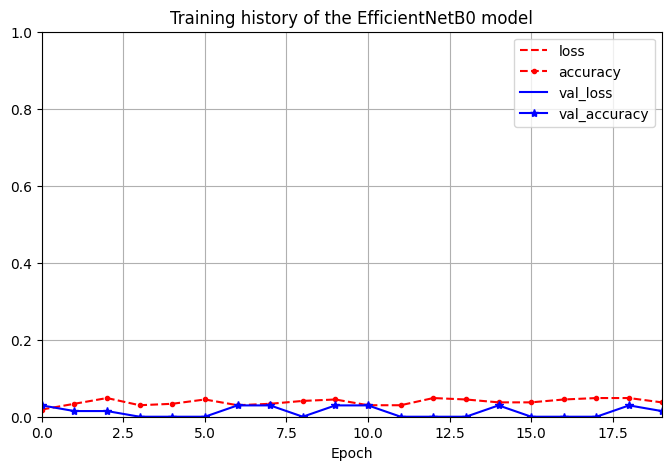

In [ ]:
# Plot the accuracy and loss over time
pd.DataFrame(history_EfficientNetB0.history).plot(
    figsize=(8, 5), xlim=[0, 19], ylim=[0, 1], grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"])
plt.title("Training history of the EfficientNetB0 model")
plt.show()

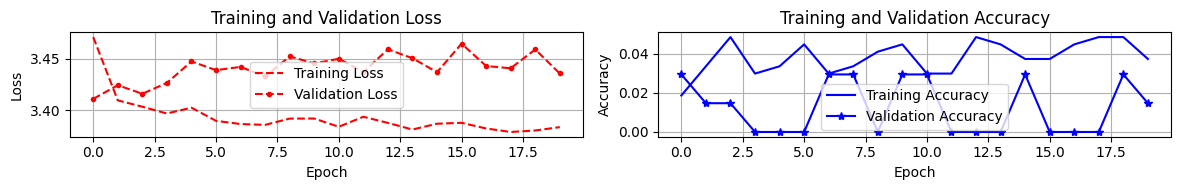

In [ ]:
# Create subplots with two axes side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 2))

# Plot the loss
ax1.plot(history_EfficientNetB0.history['loss'], 'r--', label='Training Loss')
ax1.plot(history_EfficientNetB0.history['val_loss'], 'r--.', label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

# Plot the accuracy
ax2.plot(history_EfficientNetB0.history['accuracy'], 'b-', label='Training Accuracy')
ax2.plot(history_EfficientNetB0.history['val_accuracy'], 'b-*', label='Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

# Adjust the spacing between subplots
fig.tight_layout()

# Display the plots
plt.show()

In [ ]:
# EfficientNetB0 prediction
y_pred_EfficientNetB0 = model_EfficientNetB0.predict(x_test)
y_pred_labels_EfficientNetB0 = np.argmax(y_pred_EfficientNetB0, axis=1)
predicted_flat_labels_EfficientNetB0 = encoder.inverse_transform(y_pred_labels_EfficientNetB0)
y_true_labels = np.argmax(y_test, axis=1)
true_flat_labels = encoder.inverse_transform(y_true_labels)

3/3 [==============================] - 2s 409ms/step


In [ ]:
# EfficientNetB0 landmarks report
print(classification_report(true_flat_labels, predicted_flat_labels_EfficientNetB0, digits=4))

                                          precision    recall  f1-score   support

                Gothic_ChartresCathedral     0.0000    0.0000    0.0000         6
                 Gothic_CologneCathedral     0.0000    0.0000    0.0000         2
                   Gothic_MilanCathedral     0.0000    0.0000    0.0000         2
              Gothic_Notre-DameCathedral     0.0000    0.0000    0.0000         3
                Gothic_St.VitusCathedral     0.0000    0.0000    0.0000         3
                Modern_CCTV Headquarters     0.0000    0.0000    0.0000         1
             Modern_Cathedral of Bras§ia     0.0000    0.0000    0.0000         1
                Modern_Chrysler Building     0.0000    0.0000    0.0000         3
                   Modern_Hallgr№skirkja     0.0000    0.0000    0.0000         4
                           Modern_eiffel     0.0000    0.0000    0.0000         2
                  Mughal_Bibi Ka Maqbara     0.0000    0.0000    0.0000         4
               

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# EfficientNetB0 categories report
true_categories = [label.split('_')[0] for label in true_flat_labels]
predicted_categories_EfficientNetB0 = [label.split('_')[0] for label in predicted_flat_labels_EfficientNetB0]
print(classification_report(true_categories, predicted_categories_EfficientNetB0, digits=4))

              precision    recall  f1-score   support

      Gothic     0.0000    0.0000    0.0000        16
      Modern     0.0000    0.0000    0.0000        11
      Mughal     0.0000    0.0000    0.0000        11
Neoclassical     0.0000    0.0000    0.0000        17
     Pagodas     0.0000    0.0000    0.0000        11
    Pyramids     0.2143    1.0000    0.3529        18

    accuracy                         0.2143        84
   macro avg     0.0357    0.1667    0.0588        84
weighted avg     0.0459    0.2143    0.0756        84



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### *VGG 16*




In [ ]:
# define the input shape
input_shape = (224, 224, 3)

# load the pre-trained VGG16 model
base_model = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)

# add a GlobalAveragePooling2D layer and a Dense output layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(30, activation='softmax')(x)

# create the final model
model_vgg = Model(inputs=base_model.input, outputs=predictions)

# freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# compile the model
model_vgg.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
# vgg model fitting
history_vgg = model_vgg.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=32)

Epoch 1/20
9/9 [==============================] - 11s 537ms/step - loss: 3.5882 - accuracy: 0.0448 - val_loss: 3.2832 - val_accuracy: 0.0147
Epoch 2/20
9/9 [==============================] - 1s 155ms/step - loss: 2.9977 - accuracy: 0.1903 - val_loss: 3.0103 - val_accuracy: 0.1912
Epoch 3/20
9/9 [==============================] - 1s 161ms/step - loss: 2.5517 - accuracy: 0.3918 - val_loss: 2.5495 - val_accuracy: 0.4118
Epoch 4/20
9/9 [==============================] - 1s 151ms/step - loss: 2.0894 - accuracy: 0.4851 - val_loss: 2.1999 - val_accuracy: 0.5294
Epoch 5/20
9/9 [==============================] - 1s 153ms/step - loss: 1.6823 - accuracy: 0.6119 - val_loss: 1.9044 - val_accuracy: 0.5147
Epoch 6/20
9/9 [==============================] - 1s 158ms/step - loss: 1.3541 - accuracy: 0.6828 - val_loss: 1.6490 - val_accuracy: 0.5882
Epoch 7/20
9/9 [==============================] - 1s 159ms/step - loss: 1.0957 - accuracy: 0.7612 - val_loss: 1.5592 - val_accuracy: 0.6029
Epoch 8/20
9/9 [===

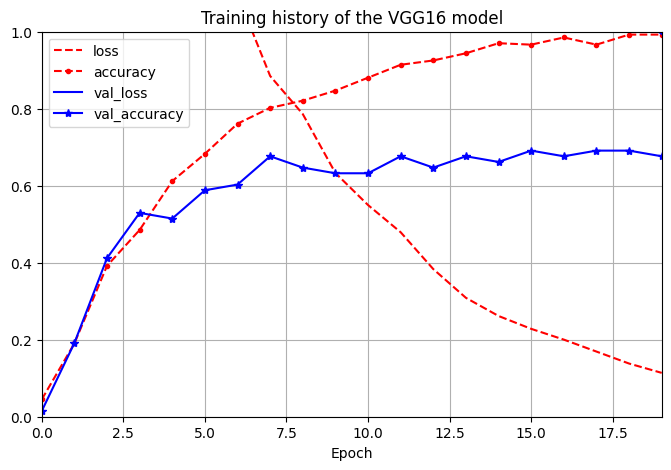

In [ ]:
# Plot the accuracy and loss over time
pd.DataFrame(history_vgg.history).plot(
    figsize=(8, 5), xlim=[0, 19], ylim=[0, 1], grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"])
plt.title("Training history of the VGG16 model")
plt.show()

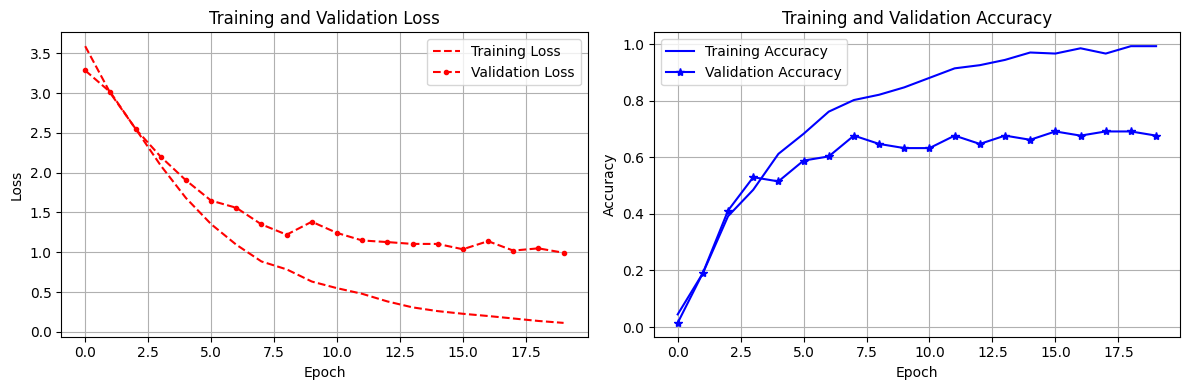

In [ ]:
# Create subplots with two axes side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot the loss
ax1.plot(history_vgg.history['loss'], 'r--', label='Training Loss')
ax1.plot(history_vgg.history['val_loss'], 'r--.', label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

# Plot the accuracy
ax2.plot(history_vgg.history['accuracy'], 'b-', label='Training Accuracy')
ax2.plot(history_vgg.history['val_accuracy'], 'b-*', label='Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

# Adjust the spacing between subplots
fig.tight_layout()

# Display the plots
plt.show()

In [ ]:
# vgg prediction
y_pred_vgg = model_vgg.predict(x_test)
y_pred_labels_vgg = np.argmax(y_pred_vgg, axis=1)
predicted_flat_labels_vgg = encoder.inverse_transform(y_pred_labels_vgg)
y_true_labels = np.argmax(y_test, axis=1)
true_flat_labels = encoder.inverse_transform(y_true_labels)

3/3 [==============================] - 3s 2s/step


In [ ]:
# vgg landmarks report
print(classification_report(true_flat_labels, predicted_flat_labels_vgg, digits=4))

                                          precision    recall  f1-score   support

                Gothic_ChartresCathedral     0.5000    0.6667    0.5714         6
                 Gothic_CologneCathedral     0.5000    0.5000    0.5000         2
                   Gothic_MilanCathedral     0.6667    1.0000    0.8000         2
              Gothic_Notre-DameCathedral     0.3333    0.3333    0.3333         3
                Gothic_St.VitusCathedral     0.0000    0.0000    0.0000         3
                Modern_CCTV Headquarters     0.0000    0.0000    0.0000         1
             Modern_Cathedral of Bras§ia     0.5000    1.0000    0.6667         1
                Modern_Chrysler Building     1.0000    0.3333    0.5000         3
                   Modern_Hallgr№skirkja     0.7500    0.7500    0.7500         4
                           Modern_eiffel     0.0000    0.0000    0.0000         2
                  Mughal_Bibi Ka Maqbara     0.6000    0.7500    0.6667         4
               

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# vgg categories report
true_categories = [label.split('_')[0] for label in true_flat_labels]
predicted_categories_vgg = [label.split('_')[0] for label in predicted_flat_labels_vgg]
print(classification_report(true_categories, predicted_categories_vgg, digits=4))

              precision    recall  f1-score   support

      Gothic     0.8235    0.8750    0.8485        16
      Modern     0.8750    0.6364    0.7368        11
      Mughal     0.9167    1.0000    0.9565        11
Neoclassical     0.9375    0.8824    0.9091        17
     Pagodas     0.7692    0.9091    0.8333        11
    Pyramids     0.8889    0.8889    0.8889        18

    accuracy                         0.8690        84
   macro avg     0.8685    0.8653    0.8622        84
weighted avg     0.8724    0.8690    0.8670        84



#### *VGG 16 with Data Augmentation*

In [ ]:
# vgg_da model fitting
history_vgg_da = model_vgg.fit(train_generator, epochs=20, validation_data=(x_val, y_val))

Epoch 1/20
9/9 [==============================] - 4s 359ms/step - loss: 0.4907 - accuracy: 0.8396 - val_loss: 1.4446 - val_accuracy: 0.6471
Epoch 2/20
9/9 [==============================] - 3s 347ms/step - loss: 0.5232 - accuracy: 0.8507 - val_loss: 1.3924 - val_accuracy: 0.5882
Epoch 3/20
9/9 [==============================] - 3s 346ms/step - loss: 0.4249 - accuracy: 0.8694 - val_loss: 1.1744 - val_accuracy: 0.6618
Epoch 4/20
9/9 [==============================] - 4s 473ms/step - loss: 0.3893 - accuracy: 0.8955 - val_loss: 1.2637 - val_accuracy: 0.6471
Epoch 5/20
9/9 [==============================] - 3s 346ms/step - loss: 0.2680 - accuracy: 0.9366 - val_loss: 1.1094 - val_accuracy: 0.6765
Epoch 6/20
9/9 [==============================] - 3s 355ms/step - loss: 0.2404 - accuracy: 0.9590 - val_loss: 1.1918 - val_accuracy: 0.6324
Epoch 7/20
9/9 [==============================] - 4s 488ms/step - loss: 0.2354 - accuracy: 0.9515 - val_loss: 1.2887 - val_accuracy: 0.6471
Epoch 8/20
9/9 [====

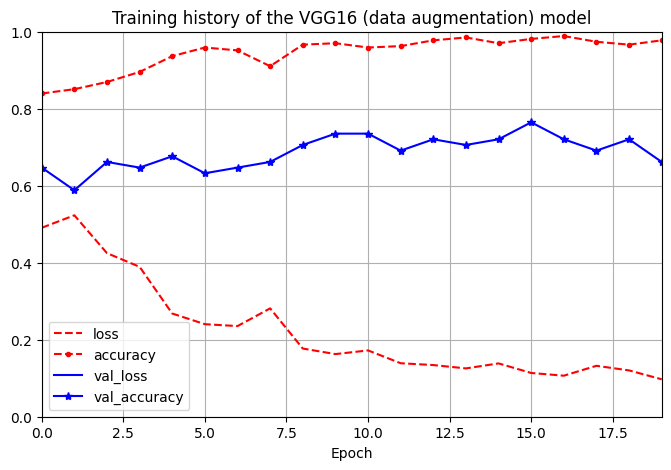

In [ ]:
# Plot the accuracy and loss over time
pd.DataFrame(history_vgg_da.history).plot(
    figsize=(8, 5), xlim=[0, 19], ylim=[0, 1], grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"])
plt.title("Training history of the VGG16 (data augmentation) model")
plt.show()

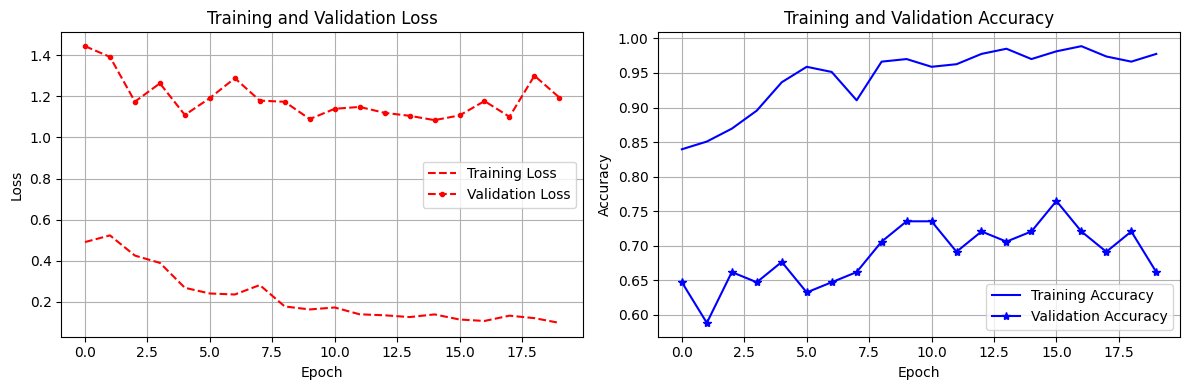

In [ ]:
# Create subplots with two axes side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot the loss
ax1.plot(history_vgg_da.history['loss'], 'r--', label='Training Loss')
ax1.plot(history_vgg_da.history['val_loss'], 'r--.', label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

# Plot the accuracy
ax2.plot(history_vgg_da.history['accuracy'], 'b-', label='Training Accuracy')
ax2.plot(history_vgg_da.history['val_accuracy'], 'b-*', label='Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

# Adjust the spacing between subplots
fig.tight_layout()

# Display the plots
plt.show()

In [ ]:
# vgg_da prediction
y_pred_vgg_da = model_vgg.predict(x_test)
y_pred_labels_vgg_da = np.argmax(y_pred_vgg_da, axis=1)
predicted_flat_labels_vgg_da = encoder.inverse_transform(y_pred_labels_vgg_da)
y_true_labels = np.argmax(y_test, axis=1)
true_flat_labels = encoder.inverse_transform(y_true_labels)

3/3 [==============================] - 0s 121ms/step


In [ ]:
# vgg_da landmarks report
print(classification_report(true_flat_labels, predicted_flat_labels_vgg_da, digits=4))

                                          precision    recall  f1-score   support

                Gothic_ChartresCathedral     0.3636    0.6667    0.4706         6
                 Gothic_CologneCathedral     0.3333    0.5000    0.4000         2
                   Gothic_MilanCathedral     0.6667    1.0000    0.8000         2
              Gothic_Notre-DameCathedral     0.0000    0.0000    0.0000         3
                Gothic_St.VitusCathedral     0.0000    0.0000    0.0000         3
                Modern_CCTV Headquarters     0.0000    0.0000    0.0000         1
             Modern_Cathedral of Bras§ia     1.0000    1.0000    1.0000         1
                Modern_Chrysler Building     0.0000    0.0000    0.0000         3
                   Modern_Hallgr№skirkja     1.0000    0.7500    0.8571         4
                           Modern_eiffel     1.0000    1.0000    1.0000         2
                  Mughal_Bibi Ka Maqbara     0.6000    0.7500    0.6667         4
               

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# vgg_da categories report
predicted_categories_vgg_da = [label.split('_')[0] for label in predicted_flat_labels_vgg_da]
print(classification_report(true_categories, predicted_categories_vgg_da, digits=4))

              precision    recall  f1-score   support

      Gothic     0.8235    0.8750    0.8485        16
      Modern     1.0000    0.5455    0.7059        11
      Mughal     0.9167    1.0000    0.9565        11
Neoclassical     1.0000    0.8824    0.9375        17
     Pagodas     0.8333    0.9091    0.8696        11
    Pyramids     0.7727    0.9444    0.8500        18

    accuracy                         0.8690        84
   macro avg     0.8910    0.8594    0.8613        84
weighted avg     0.8849    0.8690    0.8651        84



### *InceptionV3*

---



In [ ]:
# define the input shape
input_shape = (224, 224, 3)

# Load the pre-trained InceptionV3 model
base_model_iv3 = InceptionV3(include_top=False, weights='imagenet', input_shape=input_shape)

# Add a GlobalAveragePooling2D layer and a Dense output layer
x = base_model_iv3.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(30, activation='softmax')(x)

# Create the final model
model_iv3 = Model(inputs=base_model_iv3.input, outputs=predictions)

# Freeze the layers in the base model
for layer in base_model_iv3.layers:
    layer.trainable = False

# Compile the model
model_iv3.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
# iv3 model fitting
history_iv3 = model_iv3.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=32)

Epoch 1/20
9/9 [==============================] - 11s 613ms/step - loss: 10.6631 - accuracy: 0.0821 - val_loss: 7.7830 - val_accuracy: 0.1176
Epoch 2/20
9/9 [==============================] - 1s 108ms/step - loss: 4.1389 - accuracy: 0.3022 - val_loss: 2.8363 - val_accuracy: 0.1618
Epoch 3/20
9/9 [==============================] - 1s 108ms/step - loss: 2.2028 - accuracy: 0.3806 - val_loss: 2.7567 - val_accuracy: 0.1618
Epoch 4/20
9/9 [==============================] - 1s 92ms/step - loss: 1.7524 - accuracy: 0.4552 - val_loss: 2.4239 - val_accuracy: 0.4118
Epoch 5/20
9/9 [==============================] - 1s 110ms/step - loss: 1.2354 - accuracy: 0.6455 - val_loss: 1.9739 - val_accuracy: 0.4706
Epoch 6/20
9/9 [==============================] - 1s 91ms/step - loss: 0.8630 - accuracy: 0.7687 - val_loss: 1.7145 - val_accuracy: 0.4853
Epoch 7/20
9/9 [==============================] - 1s 93ms/step - loss: 0.5716 - accuracy: 0.8507 - val_loss: 1.5167 - val_accuracy: 0.5735
Epoch 8/20
9/9 [=====

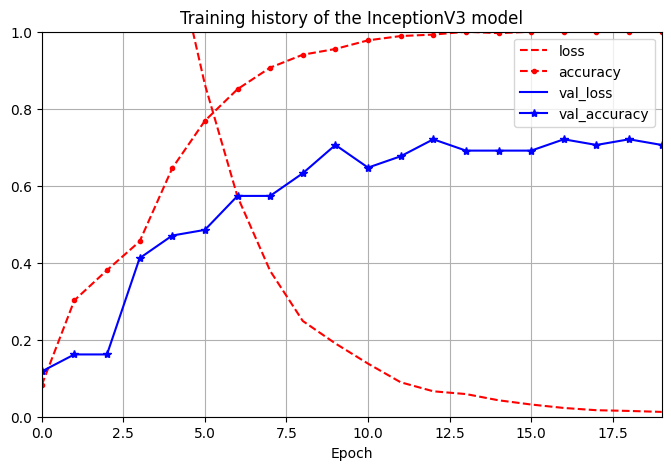

In [ ]:
# Plot the accuracy and loss over time
pd.DataFrame(history_iv3.history).plot(
    figsize=(8, 5), xlim=[0, 19], ylim=[0, 1], grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"])
plt.title("Training history of the InceptionV3 model")
plt.show()

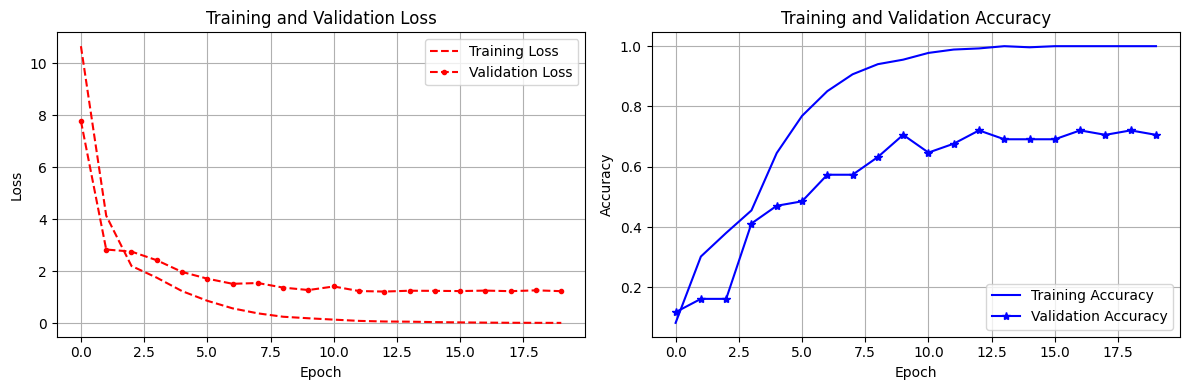

In [ ]:
# Create subplots with two axes side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot the loss
ax1.plot(history_iv3.history['loss'], 'r--', label='Training Loss')
ax1.plot(history_iv3.history['val_loss'], 'r--.', label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

# Plot the accuracy
ax2.plot(history_iv3.history['accuracy'], 'b-', label='Training Accuracy')
ax2.plot(history_iv3.history['val_accuracy'], 'b-*', label='Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

# Adjust the spacing between subplots
fig.tight_layout()

# Display the plots
plt.show()

In [ ]:
# iv3 prediction
y_pred_iv3 = model_iv3.predict(x_test)
y_pred_labels_iv3 = np.argmax(y_pred_iv3, axis=1)
predicted_flat_labels_iv3 = encoder.inverse_transform(y_pred_labels_iv3)
y_true_labels_iv3 = np.argmax(y_test, axis=1)
true_flat_labels_iv3 = encoder.inverse_transform(y_true_labels_iv3)

3/3 [==============================] - 3s 811ms/step


In [ ]:
# iv3 landmarks report
print(classification_report(true_flat_labels_iv3, predicted_flat_labels_iv3, digits=4))

                                          precision    recall  f1-score   support

                Gothic_ChartresCathedral     0.5000    0.5000    0.5000         6
                 Gothic_CologneCathedral     1.0000    1.0000    1.0000         2
                   Gothic_MilanCathedral     1.0000    1.0000    1.0000         2
              Gothic_Notre-DameCathedral     0.2500    0.3333    0.2857         3
                Gothic_St.VitusCathedral     0.3333    0.3333    0.3333         3
                Modern_CCTV Headquarters     0.0000    0.0000    0.0000         1
             Modern_Cathedral of Bras§ia     0.3333    1.0000    0.5000         1
                Modern_Chrysler Building     0.5000    0.3333    0.4000         3
                   Modern_Hallgr№skirkja     1.0000    1.0000    1.0000         4
                           Modern_eiffel     0.6667    1.0000    0.8000         2
                  Mughal_Bibi Ka Maqbara     0.6667    0.5000    0.5714         4
               

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# iv3 categories report
true_categories = [label.split('_')[0] for label in true_flat_labels]
predicted_categories_iv3 = [label.split('_')[0] for label in predicted_flat_labels_iv3]
print(classification_report(true_categories, predicted_categories_iv3, digits=4))

              precision    recall  f1-score   support

      Gothic     0.9412    1.0000    0.9697        16
      Modern     0.7500    0.8182    0.7826        11
      Mughal     0.9167    1.0000    0.9565        11
Neoclassical     1.0000    0.9412    0.9697        17
     Pagodas     0.8462    1.0000    0.9167        11
    Pyramids     0.9286    0.7222    0.8125        18

    accuracy                         0.9048        84
   macro avg     0.8971    0.9136    0.9013        84
weighted avg     0.9097    0.9048    0.9028        84



#### *InceptionV3 with Data Augmentation*

In [ ]:
# iv3_da model fitting
history_iv3_da = model_iv3.fit(train_generator, epochs=20, validation_data=(x_val, y_val))

Epoch 1/20
9/9 [==============================] - 6s 378ms/step - loss: 0.9321 - accuracy: 0.7388 - val_loss: 2.0677 - val_accuracy: 0.5882
Epoch 2/20
9/9 [==============================] - 3s 338ms/step - loss: 0.9601 - accuracy: 0.6754 - val_loss: 1.5246 - val_accuracy: 0.5882
Epoch 3/20
9/9 [==============================] - 4s 454ms/step - loss: 0.7101 - accuracy: 0.7649 - val_loss: 1.7619 - val_accuracy: 0.6176
Epoch 4/20
9/9 [==============================] - 3s 339ms/step - loss: 0.8005 - accuracy: 0.7836 - val_loss: 1.9134 - val_accuracy: 0.6471
Epoch 5/20
9/9 [==============================] - 3s 331ms/step - loss: 0.8026 - accuracy: 0.7724 - val_loss: 2.0133 - val_accuracy: 0.5441
Epoch 6/20
9/9 [==============================] - 3s 339ms/step - loss: 0.6089 - accuracy: 0.8060 - val_loss: 1.7212 - val_accuracy: 0.6324
Epoch 7/20
9/9 [==============================] - 4s 481ms/step - loss: 0.4288 - accuracy: 0.8881 - val_loss: 1.9059 - val_accuracy: 0.5441
Epoch 8/20
9/9 [====

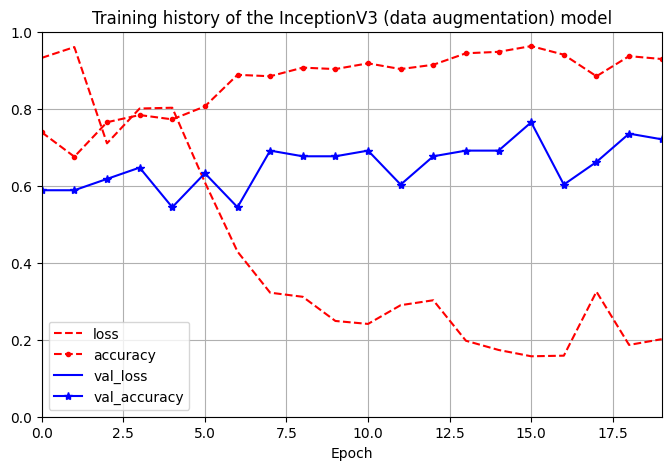

In [ ]:
# Plot the accuracy and loss over time
pd.DataFrame(history_iv3_da.history).plot(
    figsize=(8, 5), xlim=[0, 19], ylim=[0, 1], grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"])
plt.title("Training history of the InceptionV3 (data augmentation) model")
plt.show()

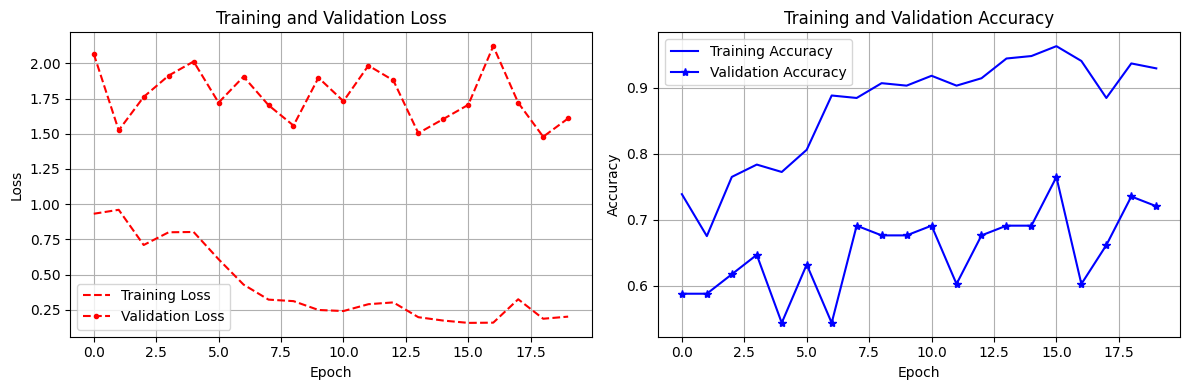

In [ ]:
# Create subplots with two axes side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot the loss
ax1.plot(history_iv3_da.history['loss'], 'r--', label='Training Loss')
ax1.plot(history_iv3_da.history['val_loss'], 'r--.', label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

# Plot the accuracy
ax2.plot(history_iv3_da.history['accuracy'], 'b-', label='Training Accuracy')
ax2.plot(history_iv3_da.history['val_accuracy'], 'b-*', label='Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

# Adjust the spacing between subplots
fig.tight_layout()

# Display the plots
plt.show()

In [ ]:
# iv3_da prediction
y_pred_iv3_da = model_iv3.predict(x_test)
y_pred_labels_iv3_da = np.argmax(y_pred_iv3_da, axis=1)
predicted_flat_labels_iv3_da = encoder.inverse_transform(y_pred_labels_iv3_da)

3/3 [==============================] - 0s 66ms/step


In [ ]:
# iv3_da landmarks report
print(classification_report(true_flat_labels, predicted_flat_labels_iv3_da, digits=4))

                                          precision    recall  f1-score   support

                Gothic_ChartresCathedral     0.4286    0.5000    0.4615         6
                 Gothic_CologneCathedral     1.0000    0.5000    0.6667         2
                   Gothic_MilanCathedral     1.0000    1.0000    1.0000         2
              Gothic_Notre-DameCathedral     0.2000    0.3333    0.2500         3
                Gothic_St.VitusCathedral     0.5000    0.3333    0.4000         3
                Modern_CCTV Headquarters     0.0000    0.0000    0.0000         1
             Modern_Cathedral of Bras§ia     0.5000    1.0000    0.6667         1
                Modern_Chrysler Building     1.0000    0.3333    0.5000         3
                   Modern_Hallgr№skirkja     1.0000    1.0000    1.0000         4
                           Modern_eiffel     1.0000    1.0000    1.0000         2
                  Mughal_Bibi Ka Maqbara     1.0000    0.7500    0.8571         4
               

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# iv3_da categories report
predicted_categories_iv3_da = [label.split('_')[0] for label in predicted_flat_labels_iv3_da]
print(classification_report(true_categories, predicted_categories_iv3_da, digits=4))

              precision    recall  f1-score   support

      Gothic     0.9412    1.0000    0.9697        16
      Modern     0.8889    0.7273    0.8000        11
      Mughal     0.9167    1.0000    0.9565        11
Neoclassical     1.0000    0.8824    0.9375        17
     Pagodas     0.9167    1.0000    0.9565        11
    Pyramids     0.8947    0.9444    0.9189        18

    accuracy                         0.9286        84
   macro avg     0.9264    0.9257    0.9232        84
weighted avg     0.9299    0.9286    0.9266        84



## Three Models evaluation

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

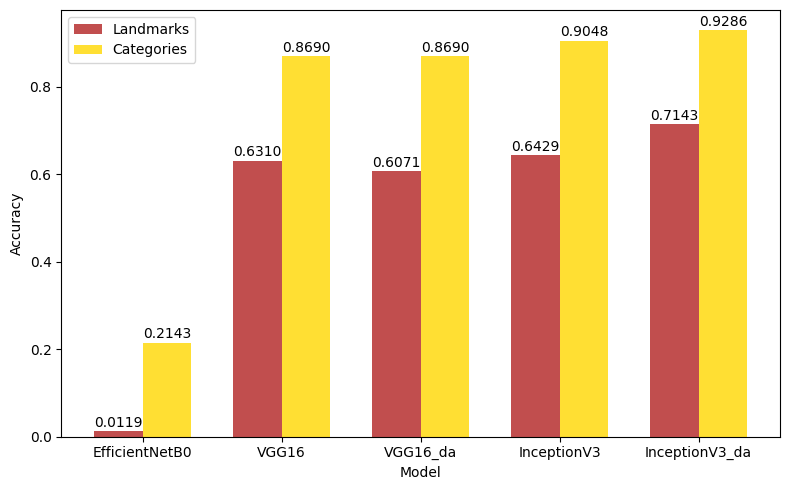

In [ ]:
acc_landmarks_EfficientNetB0= classification_report(true_flat_labels, predicted_flat_labels_EfficientNetB0, digits=4, output_dict=True)['accuracy']
acc_categories_EfficientNetB0= classification_report(true_categories, predicted_categories_EfficientNetB0, digits=4, output_dict=True)['accuracy']

acc_landmarks_vgg= classification_report(true_flat_labels, predicted_flat_labels_vgg, digits=4, output_dict=True)['accuracy']
acc_categories_vgg= classification_report(true_categories, predicted_categories_vgg, digits=4, output_dict=True)['accuracy']
acc_landmarks_vgg_da = classification_report(true_flat_labels, predicted_flat_labels_vgg_da, digits=4, output_dict=True)['accuracy']
acc_categories_vgg_da = classification_report(true_categories, predicted_categories_vgg_da, digits=4, output_dict=True)['accuracy']

acc_landmarks_iv3= classification_report(true_flat_labels, predicted_flat_labels_iv3, digits=4, output_dict=True)['accuracy']
acc_categories_iv3= classification_report(true_categories, predicted_categories_iv3, digits=4, output_dict=True)['accuracy']
acc_landmarks_iv3_da = classification_report(true_flat_labels, predicted_flat_labels_iv3_da, digits=4, output_dict=True)['accuracy']
acc_categories_iv3_da = classification_report(true_categories, predicted_categories_iv3_da, digits=4, output_dict=True)['accuracy']
# Create a dictionary containing the accuracy values for each model
acc_data = {
    'EfficientNetB0': {'landmarks': acc_landmarks_EfficientNetB0, 'categories': acc_categories_EfficientNetB0},
    'VGG16': {'landmarks': acc_landmarks_vgg, 'categories': acc_categories_vgg},
    'VGG16_da': {'landmarks': acc_landmarks_vgg_da, 'categories': acc_categories_vgg_da},
    'InceptionV3': {'landmarks': acc_landmarks_iv3, 'categories': acc_categories_iv3},
    'InceptionV3_da': {'landmarks': acc_landmarks_iv3_da, 'categories': acc_categories_iv3_da}
}

# Convert the dictionary to a pandas DataFrame and transpose it
df = pd.DataFrame(acc_data).T

# Set the size of the figure and create a grouped bar chart
fig, ax = plt.subplots(figsize=(8, 5))
bar_width = 0.35
opacity = 0.8

# Plot the accuracy values for landmarks and categories side by side for each model
for i, model in enumerate(df.index):
    landmarks = df.loc[model, 'landmarks']
    categories = df.loc[model, 'categories']
    ax.bar(i - bar_width/2, landmarks, bar_width, alpha=opacity, color='firebrick', label='Landmarks')
    ax.bar(i + bar_width/2, categories, bar_width, alpha=opacity, color='gold', label='Categories')
    # Add the accuracy values on top of each bar
    ax.text(i - bar_width/2, landmarks + 0.01, f'{landmarks:.4f}', ha='center', fontsize=10)
    ax.text(i + bar_width/2, categories + 0.01, f'{categories:.4f}', ha='center', fontsize=10)

# Add the x-axis labels and legend
ax.set_xticks(range(len(df.index)))
ax.set_xticklabels(df.index)
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
ax.legend(['Landmarks', 'Categories'])

# Show the plot
plt.tight_layout()
plt.show()

### Test on a new image

---



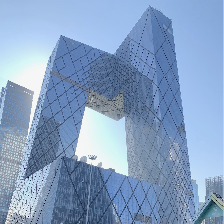

In [ ]:
# Load the new image and preprocess it
new_image_path = '/content/gdrive/My Drive/Landmarks_test/CCTVHQ.jpeg'
load_img(new_image_path, target_size=(224, 224))

In [ ]:
new_image = load_img(new_image_path, target_size=(224, 224))
new_image = img_to_array(new_image)
new_image = np.expand_dims(new_image, axis=0)
new_image = new_image / 255.0

# vgg
# Predict the probabilities using the trained model
probabilities_vgg = model_vgg.predict(new_image)

# Get the top predicted class index
top_class_index = np.argmax(probabilities_vgg)

# Decode the index back to category and landmark labels
top_class_label = encoder.inverse_transform([top_class_index])[0]
category_label, landmark_label = top_class_label.split('_')

print(f"\nPredicted Category: {category_label}, Predicted Landmark: {landmark_label}")

1/1 [==============================] - 1s 592ms/step

Predicted Category: Modern, Predicted Landmark: CCTV Headquarters


In [ ]:
# Get the predicted landmark index and its probability
predicted_landmark_index_vgg = np.argmax(probabilities_vgg)
predicted_landmark_prob_vgg = probabilities_vgg[0][predicted_landmark_index_vgg]

# Get the predicted landmark label
predicted_landmark_label_vgg = encoder.inverse_transform([predicted_landmark_index_vgg])

# Split the landmark label into category and landmark name
predicted_category_vgg, predicted_landmark_name_vgg = predicted_landmark_label_vgg[0].split('_', 1)

# Calculate the total probabilities for the category and landmark
category_prob_sum = 0
landmark_prob_sum = 0

for i, label in enumerate(encoder.classes_):
    category, landmark_name = label.split('_', 1)
    if category == predicted_category_vgg:
        category_prob_sum += probabilities_vgg[0][i]
    if landmark_name == predicted_landmark_name_vgg:
        landmark_prob_sum += probabilities_vgg[0][i]

# Print the results
print(f"Predicted Category: {predicted_category_vgg}")
print(f"Category Confidence: {category_prob_sum:.4f}")
print(f"Predicted Landmark: {predicted_landmark_name_vgg}")
print(f"Landmark Confidence: {landmark_prob_sum:.4f}")


Predicted Category: Modern
Category Confidence: 0.9420
Predicted Landmark: CCTV Headquarters
Landmark Confidence: 0.9414


In [ ]:
# iv3
# Predict the probabilities using the trained model
probabilities_iv3 = model_iv3.predict(new_image)

# Get the top predicted class index
top_class_index = np.argmax(probabilities_iv3)

# Decode the index back to category and landmark labels
top_class_label = encoder.inverse_transform([top_class_index])[0]
category_label, landmark_label = top_class_label.split('_')

print(f"\nPredicted Category: {category_label}, Predicted Landmark: {landmark_label}")

1/1 [==============================] - 1s 901ms/step

Predicted Category: Modern, Predicted Landmark: CCTV Headquarters


In [ ]:
# Save the vgg model
model_vgg.save('landmark_model_vgg.h5')

In [ ]:
from google.colab import files
files.download('landmark_model_vgg.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>